THIS NOTEBOOK AIMS TO TRAIN VIT L 16 OXFORD III PETS DATASET

In [1]:
import torch
import torchvision
from torchinfo import summary
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

/home/emir/miniconda3/envs/mlptorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [36]:
vit_l_16_weights = torchvision.models.ViT_L_16_Weights.DEFAULT
vit_l_16_model = torchvision.models.vit_l_16(vit_l_16_weights).to(device)

/home/emir/miniconda3/envs/mlptorch/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [4]:
from train_model import print_summary

In [37]:
summary(model=vit_l_16_model, 
          input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
          # col_names=["input_size"], # uncomment for smaller output
          col_names=["input_size", "output_size", "num_params", "trainable"],
          col_width=20,
          row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           1,024                True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 1024, 14, 14]   787,456              True
├─Encoder (encoder)                                          [32, 197, 1024]      [32, 197, 1024]      201,728              True
│    └─Dropout (dropout)                                     [32, 197, 1024]      [32, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [32, 197, 1024]      [32, 197, 1024]      --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 1024]      [32, 197, 1024]      12,596,224           True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 1024]      [32, 197, 10

In [6]:
vit_transforms = vit_l_16_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[242]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [7]:
dataset_dir = "../datasets/"

In [8]:
transform_tensor = transforms.Compose([
    transforms.Resize(size=[224]),
    transforms.ToTensor()])

In [16]:
train_data = torchvision.datasets.OxfordIIITPet(root=dataset_dir,
                                                download=True,
                                                split="trainval",
                                                transform=vit_transforms)
test_data = torchvision.datasets.OxfordIIITPet(root=dataset_dir,
                                                download=True,
                                                transform=vit_transforms,
                                                split="test")

In [17]:
from prepare_data import create_dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(train_data=train_data, test_data=test_data, data_folder_imported=True, transform=vit_transforms, batch_size=32)

In [18]:
class_names

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

lets show some images

In [13]:
len(train_dataloader), len(test_dataloader)

(115, 115)

In [14]:
len(train_data)

3680

In [28]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[2], label_batch[2]

In [23]:
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Miniature Pinscher')

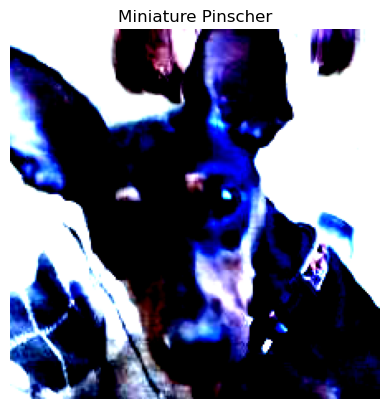

In [29]:
#should permute
plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label])

In [39]:
for parameter in vit_l_16_model.parameters():
    parameter.requires_grad = False

In [41]:
vit_l_16_model.heads = nn.Sequential(nn.Linear(in_features=1024, out_features=len(class_names)))
summary(model=vit_l_16_model, 
          input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
          # col_names=["input_size"], # uncomment for smaller output
          col_names=["input_size", "output_size", "num_params", "trainable"],
          col_width=20,
          row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 37]             1,024                Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 1024, 14, 14]   (787,456)            False
├─Encoder (encoder)                                          [32, 197, 1024]      [32, 197, 1024]      201,728              False
│    └─Dropout (dropout)                                     [32, 197, 1024]      [32, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [32, 197, 1024]      [32, 197, 1024]      --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 1024]      [32, 197, 1024]      (12,596,224)         False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 1024]      [32, 

In [ ]:
learning rate decay(cosine), gradient clipping, learning rate warmup 